# Conferencia de Prensa Matutina

In [38]:
import re
import pickle
import pandas as pd
from unidecode import unidecode # pip install
from requests_html import HTMLSession
from tqdm.notebook import tqdm 

# Parte 1: Haciendo una primera llamada a la página

In [43]:
url = "https://lopezobrador.org.mx/transcripciones/"
with HTMLSession() as sess:
    r = sess.get(url)

In [47]:
len(r.html.find("article"))

6

In [66]:
def extract_articles(sess, page):
    """
    Extrae todos los artículos de la página `page`
    """
    url = f"https://lopezobrador.org.mx/transcripciones/page/{page}/"
    r = sess.get(url)
    articles = r.html.find("article")
    return articles

In [73]:
from time import sleep

all_articles = []

with HTMLSession() as sess:
    for page in tqdm(range(1, 51)):
        articles = extract_articles(sess, page)
        all_articles.extend(articles)
        sleep(0.5)

In [74]:
len(all_articles)

300

In [79]:
print(url)

https://lopezobrador.org.mx/transcripciones/


## Paso 2: analizando un articulo

Extraer:
* url:
* title
* fecha
* author

In [ ]:
article = all_articles[0]

class_title = "h2[class='entry-title']"
class_date = "span[class='entry-date']"
class_author = "span[class='entry-author']"

In [184]:
url_article, *_ = article.find(class_title, first=True).absolute_links
title = article.find(class_title, first=True).text
date_str = article.find(class_date, first=True).text
author = article.find(class_author, first=True).text

In [ ]:
datetime.strptime() # string parse time -> datetime
datetime.strftime() # string format time -> str

In [121]:
datetime.today().strftime("%B %d, %Y")

'February 27, 2020'

In [122]:
import locale
locale.setlocale(locale.LC_TIME, "es_ES.UTF-8")

'es_ES.UTF-8'

In [126]:
date = datetime.strptime(date_str, "%B %d, %Y")

In [130]:
import antigravity

In [186]:
def extract_info(article):
    class_title = "h2[class='entry-title']"
    class_date = "span[class='entry-date']"
    class_author = "span[class='entry-author']"
    
    url_article, *_ = article.find(class_title, first=True).absolute_links
    title = article.find(class_title, first=True).text
    date_str = article.find(class_date, first=True).text
    author = article.find(class_author, first=True).text
    date = datetime.strptime(date_str, "%B %d, %Y")
    id_article = article.attrs["id"].lstrip("post-")
    
    return {
        "id": id_article,
        "date": date,
        "title": title,
        "author": author,
        "url": url_article
    }

In [187]:
extract_info(article)

{'id': '120292',
 'date': datetime.datetime(2019, 8, 8, 0, 0),
 'title': 'Versión estenográfica. Diálogo con la comunidad del Hospital Rural Rodeo, en Durango',
 'author': 'by\xa0raul',
 'url': 'https://lopezobrador.org.mx/2019/08/08/version-estenografica-dialogo-con-la-comunidad-del-hospital-rural-rodeo-en-durango/'}

In [188]:
pd.__version__

'1.0.1'

In [189]:
content = [extract_info(article) for article in all_articles]
content = pd.DataFrame(content)
content = content.set_index("id")
content.head()

,date,title,author,url
id,,,,
129025,2020-02-27,Versión estenográfica de la conferencia de pre...,by raul,https://lopezobrador.org.mx/2020/02/27/version...
128982,2020-02-26,Versión estenográfica de la conferencia de pre...,by raul,https://lopezobrador.org.mx/2020/02/26/version...
128954,2020-02-25,Versión estenográfica de la conferencia de pre...,by raul,https://lopezobrador.org.mx/2020/02/25/version...
128908,2020-02-24,"Versión estenográfica. Día de la Bandera, en C...",by raul,https://lopezobrador.org.mx/2020/02/24/version...
128904,2020-02-24,Versión estenográfica de la conferencia de pre...,by raul,https://lopezobrador.org.mx/2020/02/24/version...


In [190]:
content.author.unique()

array(['by\xa0raul'], dtype=object)

In [191]:
content.title.head()

id
129025    Versión estenográfica de la conferencia de pre...
128982    Versión estenográfica de la conferencia de pre...
128954    Versión estenográfica de la conferencia de pre...
128908    Versión estenográfica. Día de la Bandera, en C...
128904    Versión estenográfica de la conferencia de pre...
Name: title, dtype: object

In [192]:
content["date"].astype("datetime64[M]")

id
129025   2020-02-01
128982   2020-02-01
128954   2020-02-01
128908   2020-02-01
128904   2020-02-01
            ...    
120381   2019-08-01
120362   2019-08-01
120332   2019-08-01
120310   2019-08-01
120292   2019-08-01
Name: date, Length: 300, dtype: datetime64[ns]

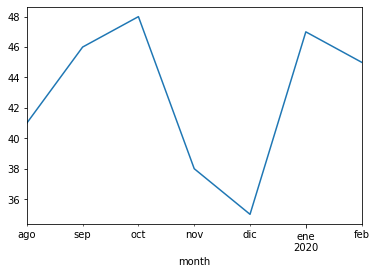

In [193]:
(content.assign(month=content["date"].astype("datetime64[M]"))
        .groupby("month")["url"]
        .count()).plot()

## Analizando conferencias

In [203]:
transcript_url = content.loc["129025", "url"]
print(transcript_url)

https://lopezobrador.org.mx/2020/02/27/version-estenografica-de-la-conferencia-de-prensa-matutina-del-presidente-andres-manuel-lopez-obrador-265/


In [200]:
with HTMLSession() as sess:
    r = sess.get(transcript_url)

In [267]:
transcript = r.html.find("div[class='entry-content']", first=True)

**Escribir un regex que encuentre todas las preguntas realizadas**

In [ ]:
regexp = re.compile("¿[^\?]+\?")
regexp.findall(transcript.text)

In [314]:
a = "esto es"

In [315]:
a += "un texto"

In [316]:
a

'esto esun texto'

In [408]:
narrativas = []
curr_text = ""

for p in transcript.find("p")[1:-1]:
    is_new_speaker = len(p.find("strong")) != 0
    if is_new_speaker:
        narrativas.append(unidecode(curr_text))
        curr_text = p.text
    else:
        curr_text += f" {p.text}"

In [409]:
from collections import defaultdict

In [410]:
default = defaultdict(list)

In [411]:
dict1 = defaultdict(list)

dict1["amlo"].append(1)

In [ ]:
regexp = re.compile("([A-Z ,]+)(?=:)")
narr = narrativas[4]
match = regexp.search(narr)
quien, *_ = match.groups()
inicio, fin = match.span()

narr[fin + 1:].lstrip()

In [445]:
regexp = re.compile("([A-Z ,]+)(?=:)")
dialogos = defaultdict(list)

for narrativa in narrativas[1:]:
    match = regexp.search(narrativa)
    if match is not None:
        quien, *_ = match.groups()
        quien, *_ = quien.split(",")
        inicio, fin = match.span()
        dialogo = narrativa[fin + 1:].lstrip()
        dialogos[quien].append(dialogo)

In [448]:
a = [1, 2, 3]
ai, *bi =  a

In [451]:
for key in dialogos.keys():
    print(key)

MODERADOR
CIPRIANO RAMIREZ
VOZ MUJER
VOZ HOMBRE
MARTHA DELGADO PERALTA
NATALIA TOLEDO PAZ
PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR
PREGUNTA
INTERLOCUTORA
ESTEBAN MOCTEZUMA BARRAGAN
INTERLOCUTOR


In [456]:
{quien: len(dialogos) for quien, dialogos in dialogos.items()}

{'MODERADOR': 10,
 'CIPRIANO RAMIREZ': 1,
 'VOZ MUJER': 5,
 'VOZ HOMBRE': 2,
 'MARTHA DELGADO PERALTA': 1,
 'NATALIA TOLEDO PAZ': 1,
 'PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR': 36,
 'PREGUNTA': 17,
 'INTERLOCUTORA': 11,
 'ESTEBAN MOCTEZUMA BARRAGAN': 6,
 'INTERLOCUTOR': 13}